In [1]:
import pandas as pd
from modules.db_manager import DBManager
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import dendrogram
import numpy as np
from sklearn import cluster
from tqdm import tqdm
from modules.logger import Logger
from time import process_time

In [2]:
def price_repair(str_repr):
    if str_repr:
        return str_repr.split(',')[1]
    else:
        return str_repr
    
def developers_repair(list_reprs):
    if list_reprs:
        return list_reprs[0]
    return list_reprs

def publishers_repair(list_reprs):
    if list_reprs:
        return list_reprs[0]
    return list_reprs

def platforms_repair(str_repr):
    if str_repr:
        str_repr = str_repr[1:-1].split(',')
        hs = 0
        for i in range(3):
            if str_repr[i] == 't':
                hs += 2**i
        return hs
    return str_repr

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

In [3]:
logger = Logger()
manager = DBManager()

In [4]:
tags_cols = ['id', 'name']
categories_cols = ['id', 'type', 'internal_name', 'display_name', 'image_url']
apps_cols = [
            "id",  
            "name",  
            "type",
            "required_age",  
            "is_free",
            "controller_support",  
            "detailed_description",  
            "about_the_game",  
            "short_description",  
            "supported_languages",  
            "header_image",  
            "website",  
            "pc_requirements",
            "mac_requirements", 
            "linux_requirements",
            "legal_notice",  
            "developers",  
            "publishers",  
            "price_overview",
            "packages",
            "package_groups",
            "platforms",
            "screenshots",
            "achievements",
            "release_date", 
            "support_info",
            "background",  
            "background_raw",
            "content_descriptors"
]
tags_df = pd.DataFrame(data=manager.get_tags(), columns=tags_cols)
categories_df = pd.DataFrame(data=manager.get_categories(), columns=categories_cols)
apps_df = pd.DataFrame(data=manager.get_apps(), columns=apps_cols)

In [5]:
logger.write(
'''
# Столбцы датасета
## Теги
'''
)
logger.write_list(tags_cols)
logger.write('## Категории')
logger.write_list(categories_cols)
logger.write('## Приложения')
logger.write_list(apps_cols)

In [6]:
whole_count = apps_df.count()[0]
nulls = [col for col in apps_df.columns if apps_df[col].isnull().sum() > 0]
nulls_count_by_column = [
    (c, apps_df[c].isnull().sum()) for c in nulls
]
to_drop = [
    col[0] for col in nulls_count_by_column if col[1] == whole_count
]
apps_df.drop(columns=to_drop, inplace=True)
nulls = [col for col in apps_df.columns if apps_df[col].isnull().sum() > 0]
stats = [(c, int(apps_df[c].isnull().sum()), round(apps_df[c].isnull().mean()*100, 2).__str__()+'%%') for c in nulls]

In [7]:
logger.write('# Статистика Датасета')
logger.write('## Количество строк: {}'.format(whole_count))
logger.write('## Количество пустых значений по столбцам')
logger.write_list(stats)
logger.write('## Столбцы, подлежащие удалению')
logger.write_list(to_drop)

In [8]:
new_apps_df = apps_df.drop(columns=['detailed_description', 'about_the_game', 'short_description', 'supported_languages', 'header_image', 'website',
                      'pc_requirements', 'mac_requirements', 'linux_requirements', 'screenshots', 'background', 'background_raw', 'name', 'legal_notice', 'id'])

In [9]:
logger.write('# Очистка таблиц от лишних столбцов и пустых значений')
logger.write('## Изначальная талица')
logger.write_table(apps_df.head())

logger.write('## Таблица после удаления лишних столбцов')
logger.write_table(new_apps_df.head())

In [10]:
apps_df = new_apps_df
apps_df['price_overview'] = apps_df['price_overview'].apply(price_repair)
apps_df['developers'] = apps_df['developers'].apply(developers_repair)
apps_df['publishers'] = apps_df['publishers'].apply(publishers_repair)
apps_df['platforms'] = apps_df['platforms'].apply(platforms_repair)

In [11]:
logger.write('## Обрабатываем колонки')
logger.write_list(['price_overview', 'developers', 'publishers', 'platforms'])
logger.write_table(apps_df.head())

In [12]:
whole_count = apps_df.count()[0]
nulls = [col for col in apps_df.columns if apps_df[col].isnull().sum() > 0]
stats = [(c, int(apps_df[c].isnull().sum()), round(apps_df[c].isnull().mean()*100, 2).__str__()+'%%') for c in nulls]

In [13]:
logger.write('## Удаляем пропуски')
logger.write('Пустые значеня до')
logger.write_list(stats)
logger.write(f'Всего строк: {whole_count}')

In [14]:
apps_df.dropna(inplace=True)
whole_count = apps_df.count()[0]
nulls = [col for col in apps_df.columns if apps_df[col].isnull().sum() > 0]
stats = [(c, int(apps_df[c].isnull().sum()), round(apps_df[c].isnull().mean()*100, 2).__str__()+'%%') for c in nulls]

In [15]:
logger.write('Пустые значеня после')
logger.write_list(stats)
logger.write(f'Всего строк: {whole_count}')

In [16]:
le = LabelEncoder()
apps_df['type'] = le.fit_transform(apps_df['type'])
apps_df['developers'] = le.fit_transform(apps_df['developers'])
apps_df['publishers'] = le.fit_transform(apps_df['publishers'])

In [17]:
logger.write('## Кодируем категориальные признаки')
logger.write('Признаки для кодирования:')
logger.write_list(['type', 'developers', 'publishers'])
logger.write('**Результат кодирования**')
logger.write_table(apps_df.head())
logger.write('## Проводим кластеризацию')

100%|██████████| 21/21 [01:25<00:00,  4.06s/it]


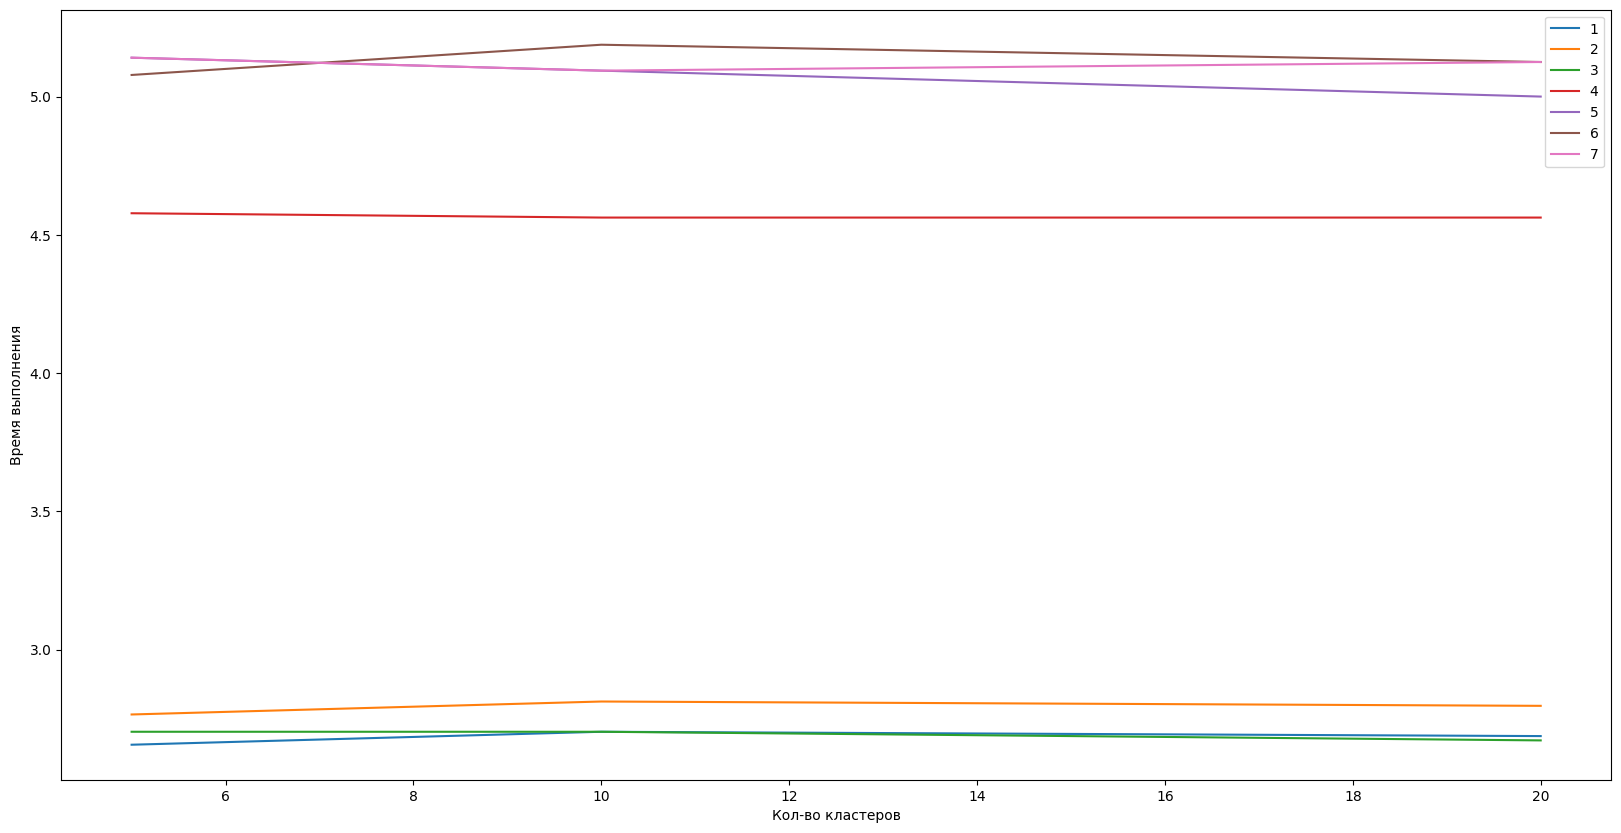

In [18]:
start_alg = process_time()
f = plt.figure(figsize=(20,10))
plt.xlabel('Кол-во кластеров')
plt.ylabel('Время выполнения')
bar = tqdm(total=21)
legends = []

for i in range(1, len(apps_df.columns)+1):
    clusters = []
    times = []
    for n_clusters in [5,10,20]:
        start_iter = process_time()
        model = cluster.AgglomerativeClustering(n_clusters=n_clusters, distance_threshold=None, compute_distances=True)
        model = model.fit(apps_df[apps_df.columns[:i]])
        end_iter = process_time() - start_iter
        
        clusters.append(n_clusters)
        times.append(end_iter)
        
        logger.write(f'Кол-во кластеров: {n_clusters}')
        logger.write(f'Время выполнения: {end_iter}')
        bar.update()

    end_alg = process_time() - start_alg
    logger.write(f'__Все время выполения алгоритма__: {end_alg}')
    logger.write('***')
    plt.plot(clusters, times, label=f'{i}')
    legends.append(f'{i}')
bar.close()
plt.legend(legends)
plt.savefig(
    logger.folder + '/' + logger.diagrams+'/'+f'time_diagram', 
    dpi='figure'
)
logger.write('## График зависимости времени выпоолнения от кол-ва кластеров')
logger.write_image('Временная диаграмма', 'time_diagram')